Hunter Bennett | Glass Lab | Kupffer Strains Project | 4 June 2021

This is a re-vamp of the differential peak calling pipeline for comparisons within strains in a given condition (healthy, CCl4, NASH). This pipeline takes in ATAC-seq peaks annotated with H3K27Ac ChIP-seq data (or other histone modified data) from three strains (c57, balb, and aj) and compares each strain to the other pairwise. The main outputs of this file are:
1. A homer differential peak file containing each pairwise comparison.
2. Scatterplots of each pairwise comparison with significant peaks highlighted.
3. Heatmaps of differential peaks across all comparisons to highlight patterns.
4. Peak files for GREAT analysis of functional annotations associated with genomic regions.

In [1]:
### header ###
__author__ = "Hunter Bennett"
__license__ = "BSD"
__email__ = "hunter.r.bennett@gmail.com"
%load_ext autoreload
%autoreload 2
### imports ###
import sys
%matplotlib inline
import os
import re
import glob
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns
matplotlib.rcParams['savefig.dpi'] = 200
sns.set(font_scale=1)
sns.set_context('talk')
sns.set_style('white')

# import custom functions
import sys
sys.path.insert(0, '/home/h1bennet/code/')
from hbUtils import ngs_qc, quantile_normalize_df
from plotting_scripts import label_point, pca_rpkm_mat, get_diff_volcano
from homer_preprocessing import read_annotated_peaks, import_homer_diffpeak, pull_comparisons_get_diff

In [2]:
dataDirectory = '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed//'
workingDirectory = '/home/h1bennet/strains_f1/results/00_CB6F1_Control/'
if not os.path.isdir(workingDirectory):
    os.mkdir(workingDirectory)
os.chdir(workingDirectory)

if not os.path.isdir('./diff_output/'):
    os.mkdir('./diff_output/')


In [3]:
balb_paths = ['/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
           '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
           '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam']

c57_paths = ['/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
           '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
           '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_c57bl6j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_C571104_TDT_l20201212_TAATACAG_ATATTCAC_S31_L001.c57bl6j.bowtie2_shifted_from_C57BL6J.sam']

balb_ids = ['BALB10ABC', 'BALB11AB', 'BALB1104']
c57_ids = ['C571A', 'C572A', 'C571104']

ids = ['balbcj_kupffer_control_young',
       'c57bl6j_kupffer_control_young']

colors = ['#377eb8',
          '#4daf4a']

paths = [';'.join(balb_paths),
         ';'.join(c57_paths)]
short_ids = [';'.join(balb_ids),
             ';'.join(c57_ids)]

pd.DataFrame([ids,colors,paths,short_ids]).T.to_csv('./sampleDefF0.txt',
                                                    sep='\t',
                                                    header=False,
                                                    index=False)

    source activate r-ouyangPipe

    mkdir ./peakQuanF0/

    mkdir ./peakDiffF0/

    nohup peakQuan.R ./sampleDefF0.txt -o ./peakQuanF0/ -g mm10 -a chip \
    -p ~/strains_f1/data/annotate_mutations_merge_f0_f1.idr \
    --homer='-size 1000 -pc 0' > peakQuanF0.nohup.out

    nohup peakDiff.R ./sampleDefF0.txt -o ./peakDiffF0/ -g mm10 -a chip \
    -q ./peakQuanF0/allRawTags.txt > peakDiffF0.nohup.out


In [4]:
df, mat = read_annotated_peaks('./peakQuanF0/allRawTags.txt')

In [5]:
best_reps = ['/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb10ABC_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control/01_balbc_Kupffer_H3K27Ac_control_young_Balb11AB_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_balbcj_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_BALB1104_TDT_l20201212_AATCCGGA_CTACAGTT_S30_L001.balbcj.bowtie2_shifted_from_BALBCJ.sam',
       '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C571A_170915',
       '/home/h1bennet/strains/data/H3K27Ac/control/00_C57_Kupffer_H3K27Ac_control_young_C572A_180423',
       '/home/h1bennet/strains/data/H3K27Ac/control_cohort2_untrimmed/tag_mouse_c57bl6j_Male_Kupffer_ChIP_H3K27ac_Chow_healthyoung_C571104_TDT_l20201212_TAATACAG_ATATTCAC_S31_L001.c57bl6j.bowtie2_shifted_from_C57BL6J.sam']

In [6]:
# import annotation file
df, mat = read_annotated_peaks('./peakQuanF0/allRawTags.txt')

# pull out selected samples
tst = np.append(np.asarray([True]*18, 'bool'), mat.columns.str.contains('|'.join(best_reps)))
df= df.loc[:, tst]
mat = mat.loc[:, mat.columns.str.contains('|'.join(best_reps))]

df.to_csv('./peakQuan/allRawTags_onlymuts.txt', sep='\t')


# also save version that filters based on amounts of tags
groups = [[0,1,2],
         [3,4,5]]
thresh = 4
n_passing_thresh=2

peaks = []
for group in groups:
    bool_peaks = (mat.iloc[:, group] > thresh).sum(1)>n_passing_thresh
    peaks.extend(mat.index[bool_peaks])
                  
mat_filt = mat.reindex(set(peaks)).dropna()
df_filt = df.reindex(set(peaks)).dropna()

print("N IDR Peaks:", mat.shape[0])
print("N Peaks Passing Thresh:", len(set(peaks)))
print("N Filtered Peaks:", mat_filt.shape[0])

df_filt.to_csv('./peakQuanF0/allRawTags_filtered_peaks.txt', sep='\t')

# save distal version for peak calling
df_filt_distal = df_filt.reindex(df_filt.index[np.abs(df_filt['Distance to TSS']) > 3000])
df_filt_distal.to_csv('./peakQuanF0/allRawTags_filtered_peaks_distal.txt', sep='\t')


N IDR Peaks: 137971
N Peaks Passing Thresh: 92398
N Filtered Peaks: 92398


In [18]:
%%bash

source activate deseq_36
getDiffExpression.pl ./peakQuanF0/allRawTags_filtered_peaks.txt \
balbcj_h3k27ac balbcj_h3k27ac balbcj_h3k27ac \
c57bl6j_h3k27ac c57bl6j_h3k27ac c57bl6j_h3k27ac \
-peaks > ./diff_output/diff_output_h3k27ac_f0.txt

	Treating input as file generated by annotatePeaks.pl (-peaks)

	Performing variance stabalization (rlog)...



	Using DESeq2 to calculate differential expression/enrichment...
	Output Stats balbcj_h3k27ac vs. c57bl6j_h3k27ac:
		Total Genes: 86573
		Total Up-regulated in c57bl6j_h3k27ac vs. balbcj_h3k27ac: 2723 (3.145%) [log2fold>1, FDR<0.05]
		Total Dn-regulated in c57bl6j_h3k27ac vs. balbcj_h3k27ac: 2789 (3.222%) [log2fold<-1, FDR<0.05]



# Filtered peaks

In [7]:
diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
    './diff_output/diff_output_h3k27ac_f0.txt',
    './peakQuanF0/allRawTags_filtered_peaks.txt')

comp_dict = pull_comparisons_get_diff(diff_peak, seq_type='Peak')
comp_dict.keys()

annotatePeaks all peaks (86573, 24)
getDiffExpression selected transcripts (86573, 27)
annotatePeaks selected peaks (86573, 24)


dict_keys(['balbcj_h3k27ac vs. c57bl6j_h3k27ac'])

In [8]:
comps = ['balbcj_h3k27ac vs. c57bl6j_h3k27ac']

groups = [[[0,1,2],[3,4,5]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

pval = 0.05
log2fc = np.log2(2)

balbcj_h3k27ac vs. c57bl6j_h3k27ac
N peaks downregulated 2789
N peaks upregulated 2723



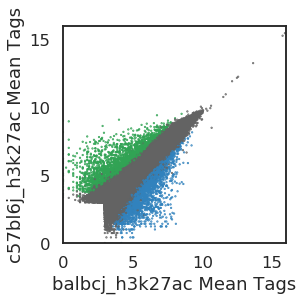

In [9]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc)))
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc)))
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext.png', bbox_inches='tight')
    # plt.close()

Reverse plot to match F1

In [10]:
comps = ['balbcj_h3k27ac vs. c57bl6j_h3k27ac']

groups = [[[3,4,5], [0,1,2]]]

cols = []
for i in groups:
    for j in i:
        cols.extend(j)
cols = [cols]

colors = [['#3182bd', '#31a354']]

pval = 0.05
log2fc = np.log2(2)

balbcj_h3k27ac vs. c57bl6j_h3k27ac
N peaks downregulated 2723
N peaks upregulated 2789



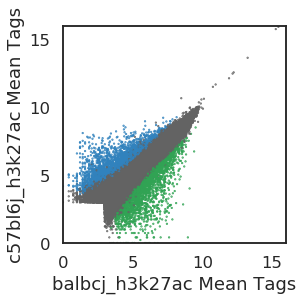

In [12]:
for key, col, group, color in zip(comps, cols, groups, colors):
    
    # make columns for plotting
    de = comp_dict[key]
    de['logtpm'] = np.log2(peak_mat.iloc[:, col].mean(1)+1)
    de['log10p'] = -np.log10(de.adj_pval + 10**(-50))
    de['g0_mean'] = np.log2(peak_mat.iloc[:, group[0]].mean(1)+1)
    de['g1_mean'] = np.log2(peak_mat.iloc[:, group[1]].mean(1)+1)
    de = de.reindex(de.index[(de.g0_mean >= 3) | (de.g1_mean >= 3)])

    dot_colors = []
    dot_sizes = []
    
    # create dot size list
    for index, row in de.iterrows():
        if (row.adj_pval <= pval) & (-row.log2fc < -log2fc):
            dot_colors.append(color[1])
            dot_sizes.append(row.log10p)
        elif (row.adj_pval <= pval) & (-row.log2fc > log2fc):
            dot_colors.append(color[0])
            dot_sizes.append(row.log10p)
        else:
            dot_colors.append('#636363')
            dot_sizes.append(0.5)
    
    # print DE peaks
    print(key)
    print('N peaks downregulated', np.sum((de.adj_pval <= pval) & (de.log2fc > log2fc))) #FLIPPED
    print('N peaks upregulated', np.sum((de.adj_pval <= pval) & (de.log2fc < -log2fc))) #FLIPPED
    print('')
    
    fig, ax = plt.subplots(figsize=(4,4))
    
        # plot group by group scatter:
    ax.scatter(
        x=de.g0_mean,
        y=de.g1_mean,
        s=0.5, #de.log10p+0.05,
        c=dot_colors)
    
    ax.set_xlabel(key.split(' vs. ')[0] + ' Mean Tags')
    ax.set_ylabel(key.split(' vs. ')[1] + ' Mean Tags')
    
    #set max and min
    countmax = np.max([np.max(de.g0_mean), np.max(de.g1_mean)])
    ax.set_xlim([0,np.ceil(countmax)])
    ax.set_ylim([0,np.ceil(countmax)])
    
#     ax.text(0.5,15,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc > 1)), key.split(' vs. ')[1]),
#         fontsize=12,
#         c=color[1])
#     ax.text(15,0.5,
#         s='%d %s spec peaks' % (np.sum((de.adj_pval <= 0.05) & (de.log2fc < -1)), key.split(' vs. ')[0]),
#         fontsize=12,
#         c=color[0],
#         rotation=-90)
    
    plt.savefig('./figures/'+key+'_scatter_notext_flipped.png', bbox_inches='tight')
    # plt.close()

# Extract target peaks
- since this was annotated with a size of 1000 bp we need to resize the peaks in homer to 200 bp (since they are annotated on ATAC-seq IDr peaks)

In [13]:
if not os.path.isdir('./motif_calling/'):
    os.mkdir('./motif_calling/') # Extract target peaks

In [14]:
convert_dict = {'Start': int,
                'End': int}

# set p value and log2fcs
pval = 0.05
log2fc = np.log2(2)

peak_dict = {}

# this is just c57 vs balb, c57 being coded as positive

for i in glob.glob('./diff_output/diff_output_h3k27ac_f0.txt'):
    diff_peak, peaks, peak_mat, peak_mat_quant = import_homer_diffpeak(
        i,
        './peakQuanF0/allRawTags_filtered_peaks.txt')
    
    # force comparison name
    strain1 = 'c57bl6j'
    strain2 = 'balbcj'
    
    # extract distal peaks only
    diff_peak_distal = diff_peak.loc[np.abs(diff_peak.loc[:, 'Distance to TSS']) >= 3000, :]
    
    # log2fc is in position -3, adj p value is in position -1
    # positive peaks are up in NASH, negative peaks are down in NASH
    balb = diff_peak.loc[(diff_peak.iloc[:, -3] <= -log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    c57 = diff_peak.loc[(diff_peak.iloc[:, -3] >= log2fc) & (diff_peak.iloc[:, -1] < pval), :].index.tolist()
    
    # activated peaks stored in the [0] position.
#     peak_dict['c57_vs_balb'] = [act, rep]
    
    # save to list
    # print(comp_name)
    print('n balb peaks:',diff_peak.reindex(balb).dropna(how='all').shape[0])
    diff_peak.reindex(balb).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_log2fc_%.1f_pval_%.2f.txt' % ('balbcj', log2fc, pval),
    sep='\t')
    
    print('n distal balb peaks:',diff_peak_distal.reindex(balb).dropna(how='all').shape[0])
    diff_peak_distal.reindex(balb).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_log2fc_%.1f_pval_%.2f.txt' % ('balbcj', log2fc, pval),
    sep='\t')
    
    print('n c57 peaks:',diff_peak.reindex(c57).dropna(how='all').shape[0])
    diff_peak.reindex(c57).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_log2fc_%.1f_pval_%.2f.txt' % ('c57bl6j', log2fc, pval),
    sep='\t')
    
    print('n distal c57 peaks:',diff_peak_distal.reindex(c57).dropna(how='all').shape[0])
    diff_peak_distal.reindex(c57).dropna(how='all').iloc[:, :4].astype(convert_dict).to_csv(
    './motif_calling/%s_distal_log2fc_%.1f_pval_%.2f.txt' % ('c57bl6j', log2fc, pval),
    sep='\t')

annotatePeaks all peaks (86573, 24)
getDiffExpression selected transcripts (86573, 27)
annotatePeaks selected peaks (86573, 24)
n balb peaks: 2789
n distal balb peaks: 2172
n c57 peaks: 2723
n distal c57 peaks: 2005


In [15]:
strain_dict = {'c57bl6j': 'c57bl6j',
               'balbcj': 'balbcj',
               'aj': 'aj'}

# background set all peaks that were considered as differential
all_peaks = './peakQuanF0/allRawTags_filtered_peaks.txt' 
all_peaks_distal = './peakQuanF0/allRawTags_filtered_peaks_distal.txt'

with open('./findMotifs_differential.sh', 'w') as f:
    for peakfile in np.sort(glob.glob('./motif_calling/*log2fc*.txt')):
        strain = peakfile.split('/')[-1].split('_')[0]
        if 'distal' in peakfile:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks_distal, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        else:
            call = ['/home/vlink/code/marge/bin/MMARGE.pl', 'denovo_motifs',
                    peakfile, 'mm10', peakfile.replace('.txt', '_motifs'),
                    '-bg', all_peaks, '-size 200',
                    '-len 8,10,12,14,16', '-fg_strain', strain_dict[strain],
                    '-bg_strain', strain_dict[strain], '-p 8\n\n']
        f.write(' '.join(call))